In [1]:
!pip3 install biopython scikit-bio torchinfo hnswlib

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
cfg = dict()
cfg['kmer_size'] = 64
cfg['embedding_dim'] = 512
cfg['batch_size'] = 100
cfg['epochs'] = 10
cfg['report_every_n_batches'] = 200
cfg['dense_layer_units'] = 8192
cfg['triplet_loss_margin'] = 0.25
cfg['learning_rate'] = 0.0000075
cfg['num_triplets'] = 100000
cfg['max_snps'] = 10
cfg['alphabet_size'] = 16
cfg['max_sw_score'] = (64.0*5)
cfg['conv1d_filters'] = [32, 64, 128]
cfg['conv1d_kernels'] = [3, 3, 3]
cfg['fc_output'] = 8192
cfg['use_pytorch_amp'] = True
cfg['force_retrain_model'] = True
cfg['parameter_dtype'] = 'float16'
cfg['model_bin'] = 'data/model.bin'
cfg['triplets_path'] = 'data/triplets.np'
cfg['triplet_swas_path'] = 'data/triplet_swas.np'

In [3]:
import os
from Bio import Entrez, SeqIO
from Bio.Seq import Seq
Entrez.email = 'anonymous@outlook.com'

# fetch samples from Entrez, the US federal database
# TODO: later these will be used to cross-validate as additional testing rounds.
# This was done historically and performance was very similar to with the random data
# supporting the training methods application to non-random input.

print("Downloading test samples for later validation...")

DATA_DIR='./data'
def EntrezFetch(db, accession, type='fasta', mode='text'):
    cached_path = DATA_DIR+'/'+db+'-'+accession
    handle = Entrez.efetch(db=db, id=accession, rettype=type, retmode=mode)
    os.makedirs(os.path.dirname(cached_path), exist_ok=True)
    with open(cached_path, "w") as f:
        f.write(handle.read())
    return cached_path

datapath = EntrezFetch('nucleotide', 'EU054331')
print(datapath)

records = SeqIO.parse(datapath, "fasta")

print("Done processing test samples.")

#for rec in records:
#    seq = Seq(str(rec.seq))
#    print(seq)

./data/nucleotide-EU054331
Done processing test samples.


In [4]:
import torch

if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev)
print(dev)

cuda:0


In [63]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm.notebook import tqdm

class SWAEmb(nn.Module):
    def __init__(self):
        super(SWAEmb, self).__init__()
    
        self.linear_fc_input = (cfg['kmer_size'] - cfg['conv1d_kernels'][0] + 1) // 2
        self.linear_fc_input = \
            (self.linear_fc_input - cfg['conv1d_kernels'][1] + 1) // 2
        self.linear_fc_input = \
            ((self.linear_fc_input - cfg['conv1d_kernels'][2] + 1) * cfg['conv1d_filters'][2]) // 2
        
        self.net = nn.Sequential(
            nn.Conv1d(cfg['alphabet_size'], cfg['conv1d_filters'][0], cfg['conv1d_kernels'][0], stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(cfg['conv1d_filters'][0], cfg['conv1d_filters'][1], cfg['conv1d_kernels'][1], stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(cfg['conv1d_filters'][1], cfg['conv1d_filters'][2], cfg['conv1d_kernels'][2], stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(in_features=self.linear_fc_input, out_features=cfg['fc_output']),
            nn.ReLU(),
            nn.Linear(in_features=cfg['fc_output'], out_features=cfg['embedding_dim'])
        )

    def forward_once(self, x):
        x = self.net(x)
        return x

    def forward(self, APN):
        A = APN[:,:,:,0]
        P = APN[:,:,:,1]
        N = APN[:,:,:,2]
        o1 = self.forward_once(A)
        o2 = self.forward_once(P)
        o3 = self.forward_once(N)

        return o1, o2, o3

class TripletLoss(nn.Module):
    def __init__(self, margin=cfg['triplet_loss_margin']):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.align_loss_samples = np.empty(shape=(0), dtype=cfg['parameter_dtype'])
        self.triplet_loss_samples = np.empty(shape=(0), dtype=cfg['parameter_dtype'])
        self.triplet_loss_margin_samples = np.empty(shape=(0), dtype=cfg['parameter_dtype'])
        self.sw_delta = np.empty(shape=(0), dtype=cfg['parameter_dtype'])


    # need to balance APscore ANscore delta and loss margin.
    # I think align loss and triplet loss my be competing currently.
    def forward(self, anchor, positive, negative, APscore, ANscore):
        p_dist = F.cosine_similarity(anchor, positive, dim=1)
        n_dist = F.cosine_similarity(anchor, negative, dim=1)
        align_loss = F.mse_loss(p_dist, APscore) + F.mse_loss(n_dist, ANscore)
        triplet_loss = F.relu(p_dist - n_dist + self.margin).mean()
        self.align_loss_samples = np.append(self.align_loss_samples, align_loss.detach().cpu().numpy())
        tp = p_dist.detach().cpu()
        tn = n_dist.detach().cpu()
        for i in range(len(p_dist)):
            self.sw_delta = np.append(self.sw_delta, APscore-ANscore)
        for i in range(len(p_dist)):
            self.triplet_loss_samples = np.append(self.triplet_loss_samples, F.relu(tp[i] - tn[i]).numpy())
        for i in range(len(p_dist)):
            self.triplet_loss_margin_samples = np.append(self.triplet_loss_margin_samples, [F.relu(tp[i] - tn[i] + self.margin).numpy(), tp[i] - tn[i]], axis=0)
        loss = align_loss + triplet_loss
        loss = loss.to(torch.device(dev))
        return loss

In [6]:
alphabet = ['a', 'c', 'g', 't', 'r', 'y', 's', 'w', 'k', 'm', 'b', 'd', 'h', 'v', 'n', '-']
alphabet_to_onehoti = dict()
onehoti_to_alphabet = dict()
alphabet_len = len(alphabet)
assert(alphabet_len == cfg['alphabet_size'])

# populate map and reverse map
for i, c in enumerate(alphabet):
    alphabet_to_onehoti[c] = i
    onehoti_to_alphabet[i] = c
    
def char_to_onhot(c):
    oh = np.zeros((alphabet_len), dtype=cfg['parameter_dtype'])
    i = alphabet_to_onehoti[c]
    oh[i] = 1
    return oh
    
def seqstr_to_onehot(seqstr):
    size = len(seqstr)
    oh = np.zeros((size, alphabet_len), dtype=cfg['parameter_dtype'])
    for off, c in enumerate(seqstr):
        i = alphabet_to_onehoti[c]
        oh[off][i] = 1
    return oh

def onehot_to_seqstr(onehot):
    size = onehot.shape[0]
    seqstr = str()
    for pos in range(size):
        i = next((idx for idx, val in np.ndenumerate(onehot[pos,:]) if val==1))[0]
        seqstr += onehoti_to_alphabet[i]
    return seqstr

In [69]:
from skbio.alignment import StripedSmithWaterman

def gen_random_seq(seqlen, alphabet):
    seq = ""
    alphabet_len = len(alphabet)
    for pos in range(seqlen):
        cidx = np.random.choice(alphabet_len)
        seq += alphabet[cidx]
    return seq

def generate_triplets_2(num_triplets, phase_delta_min, phase_delta_max, max_snps,
                        ndelta_phase, ndelta_snps):
    assert(ndelta_phase != 0)
    assert(ndelta_snps != 0)
        
    m = 0
    triplets = np.empty(shape=(num_triplets, int(cfg['kmer_size']), alphabet_len, 3), dtype=cfg['parameter_dtype'])
    triplet_swas = np.empty(shape=(num_triplets, 2), dtype=cfg['parameter_dtype'])
    
    while m < num_triplets:
        
        # generate A(nchor)
        phase_gamut = (phase_delta_max - phase_delta_min)
        # TODO: Use weighted alphabet here as well
        SA = gen_random_seq(int(cfg['kmer_size'])+(phase_gamut * 2), alphabet=['g', 'c', 'a', 't'])
        A = SA[phase_gamut:int(cfg['kmer_size'])+phase_gamut]
    
        # generate permutation spec for P(ositive)
        phase_delta = np.random.choice(phase_delta_max - phase_delta_min) + phase_delta_min
        num_snps = np.random.choice(max_snps)
    
        # generate permutation spec for N(egative)
        while True:
            nphase_delta = np.random.choice(ndelta_phase)
            if phase_delta < 0:
                nphase_delta *= -1
            nphase_delta = phase_delta + nphase_delta
            nnum_snps = np.random.choice(ndelta_snps) + num_snps
            
            # recalculate if N is no further from the anchor than P
            if (nphase_delta == phase_delta) and (num_snps == nnum_snps):
                continue
            break
    
        P = SA[phase_gamut+phase_delta:int(cfg['kmer_size'])+phase_gamut+phase_delta]
        offs = set()
        for i in range(num_snps):
            while True:
                off = np.random.choice(cfg['kmer_size'])
                idx = np.random.choice(len(alphabet))
                if P[off] == alphabet[idx]:
                    continue
                if off in offs:
                    continue
                offs.add(off)
                l=list(P)
                l[off] = alphabet[idx]
                P=''.join(l)
                break
            
        N = SA[phase_gamut+nphase_delta:int(cfg['kmer_size'])+phase_gamut+nphase_delta]
        offs = set()
        for i in range(nnum_snps):
            while True:
                off = np.random.choice(cfg['kmer_size'])
                idx = np.random.choice(len(alphabet))
                if N[off] == alphabet[idx]:
                    continue
                if off in offs:
                    continue
                offs.add(off)
                l=list(N)
                l[off] = alphabet[idx]
                N=''.join(l)
                break
    
        #print("A:", A)
        #print("P:", phase_delta, P)
        #print("N:", nphase_delta, N)
        triplets[m,:,:,0] = seqstr_to_onehot(A)
        triplets[m,:,:,1] = seqstr_to_onehot(P)
        triplets[m,:,:,2] = seqstr_to_onehot(N)
        ssw = StripedSmithWaterman(A, score_size=2)
        
        # TODO: The SWAs (optimal alignment scores) are packed to close to each other
        # need to set SW params to acheive higher score gamut without distortion
        # then apply affine transforation (scale) to fill paramater datatype repr.
        triplet_swas[m,0] = torch.tensor(ssw(P)['optimal_alignment_score'])
        triplet_swas[m,1] = torch.tensor(ssw(N)['optimal_alignment_score'])
        if (triplet_swas[m,0] == triplet_swas[m,1]):
            continue
        
        m += 1
        if (m % 1000) == 0:
            print("Triplet {}".format(m))
    
    print("Print auto-scaling triplet_swas...")
    minSwa = np.concatenate(triplet_swas[:,0], triplet_swas[:,1])
    maxSwa = np.concatenate(triplet_swas[:,0], triplet_swas[:,1])
    swaDelta = maxSwa - minSwa
    triplet_swas[:,0] /= swaDelta
    triplet_swas[:,1] /= swaDelta
    triplet_swas[:,0] -= minSwa
    triplet_swas[:,1] -= minSwa
    print("Done auto-scaling triplet swas.")
    
    return triplets, triplet_swas

if os.path.isfile(cfg['triplets_path']+'.npy'):
    print("Loading triplets from file...")
    triplets = np.load(cfg['triplets_path']+'.npy')
    triplet_swas = np.load(cfg['triplet_swas_path']+'.npy')
    print("done loading triplets from file.")
else:
    triplets, triplet_swas = generate_triplets_2(num_triplets=cfg['num_triplets'],
                                   phase_delta_min=-int(cfg['kmer_size']),
                                   phase_delta_max=int(cfg['kmer_size']),
                                   max_snps=cfg['max_snps'],
                                   ndelta_phase=2, ndelta_snps=2)
    print("Saving triplets to file...")
    np.save(cfg['triplets_path'], triplets)
    np.save(cfg['triplet_swas_path'], triplet_swas)
    print("done saving triplets to file.")
    
print('done.')

Triplet 1000
Triplet 2000
Triplet 3000
Triplet 4000
Triplet 5000
Triplet 6000
Triplet 7000
Triplet 8000
Triplet 9000
Triplet 10000
Triplet 11000
Triplet 12000
Triplet 13000
Triplet 14000
Triplet 15000
Triplet 16000
Triplet 17000
Triplet 18000
Triplet 19000
Triplet 20000
Triplet 21000
Triplet 22000
Triplet 23000
Triplet 24000
Triplet 25000
Triplet 26000
Triplet 27000
Triplet 28000
Triplet 29000
Triplet 30000
Triplet 31000
Triplet 32000
Triplet 33000
Triplet 34000
Triplet 35000
Triplet 36000
Triplet 37000
Triplet 38000
Triplet 39000
Triplet 40000
Triplet 41000
Triplet 42000
Triplet 43000
Triplet 44000
Triplet 45000
Triplet 46000
Triplet 47000
Triplet 48000
Triplet 49000
Triplet 50000
Triplet 51000
Triplet 52000
Triplet 53000
Triplet 54000
Triplet 55000
Triplet 56000
Triplet 57000
Triplet 58000
Triplet 59000
Triplet 60000
Triplet 61000
Triplet 62000
Triplet 63000
Triplet 64000
Triplet 65000
Triplet 66000
Triplet 67000
Triplet 68000
Triplet 69000
Triplet 70000
Triplet 71000
Triplet 72000
T

TypeError: only integer scalar arrays can be converted to a scalar index

In [8]:
# separate triplets into train and test sets
train_set_size = int(len(triplets) * 0.8)
test_set_size = len(triplets) - train_set_size

if (triplets.shape[1] == 64):
    triplets = np.transpose(triplets, (0,2,1,3)) # modify order for pytorch input

# Map-type dataset
class TripletsDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, data, labels):
        self.labels = labels
        self.data = data
        if (dev != 'cpu'):
            self.data = torch.from_numpy(self.data).to(torch.device(dev))
            self.labels = torch.from_numpy(self.labels).to(torch.device(dev))

  def __len__(self):
        return len(self.labels)

  def __getitem__(self, index):
        return self.data[index], self.labels[index]

train = TripletsDataset(triplets[0:train_set_size], triplet_swas[0:train_set_size])
test = TripletsDataset(triplets[-test_set_size:], triplet_swas[-test_set_size:])

train_loader = torch.utils.data.DataLoader(train, batch_size=cfg['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=cfg['batch_size'], shuffle=False)

print("Train set size:", train_set_size)
print("Test set size:", test_set_size)
print('done.')

print(triplets[0,:,:,0])
print(triplet_swas[0])

Train set size: 80000
Test set size: 20000
done.
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.0375  0.02812]


In [9]:
# Training

import os

model = SWAEmb()
scaler = torch.cuda.amp.GradScaler(enabled=cfg['use_pytorch_amp'])

requireTraining=True
if os.path.isfile(cfg['model_bin']) and not cfg['force_retrain_model']:
    print("Loading saved model...")
    model.load_state_dict(torch.load(cfg['model_bin']))
    print("done loading saved model.")
    requireTraining = False
    
if (dev != 'cpu'):
    model.to(torch.device(dev))

criterion = TripletLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate']) 

if requireTraining:
    for epoch in range(cfg['epochs']):
        batchNum = 0
        totalLoss = 0
        total = 0
        print("Training EPOCH {} of {}:".format(epoch, cfg['epochs']))
        for APN, E in tqdm(train_loader):
            autocast_devtype = 'cpu'
            if (dev != 'cpu'):
                autocast_devtype = 'cuda'
            with torch.autocast(device_type=autocast_devtype, dtype=getattr(torch, cfg['parameter_dtype']), enabled=cfg['use_pytorch_amp']):
                yA, yP, yN = model.forward(APN)
                loss = criterion(yA, yP, yN, E[:,0], E[:,1])
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            optimizer.zero_grad()
            
            total += yA.shape[0]
            totalLoss += loss
            batchNum += 1
    
            if (batchNum % cfg['report_every_n_batches'] == 0) and (batchNum != 0):
                print("    Training batch #{}: samples={}, totalLoss={}".format(batchNum, total, totalLoss))
                totalLoss = 0

    print("Training complete. saving model...")
    torch.save(model.state_dict(), cfg['model_bin'])
    print("done saving model.")

Training EPOCH 0 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=80.5698013305664
    Training batch #400: samples=40000, totalLoss=58.21382522583008
    Training batch #600: samples=60000, totalLoss=57.50479507446289
    Training batch #800: samples=80000, totalLoss=57.08212661743164
Training EPOCH 1 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=55.73674392700195
    Training batch #400: samples=40000, totalLoss=55.717567443847656
    Training batch #600: samples=60000, totalLoss=55.378387451171875
    Training batch #800: samples=80000, totalLoss=55.91329574584961
Training EPOCH 2 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=53.917911529541016
    Training batch #400: samples=40000, totalLoss=54.10609436035156
    Training batch #600: samples=60000, totalLoss=54.004119873046875
    Training batch #800: samples=80000, totalLoss=54.3918571472168
Training EPOCH 3 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=52.80364990234375
    Training batch #400: samples=40000, totalLoss=52.79985046386719
    Training batch #600: samples=60000, totalLoss=52.681182861328125
    Training batch #800: samples=80000, totalLoss=52.76927185058594
Training EPOCH 4 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=51.30143356323242
    Training batch #400: samples=40000, totalLoss=51.14896011352539
    Training batch #600: samples=60000, totalLoss=51.930240631103516
    Training batch #800: samples=80000, totalLoss=51.7202033996582
Training EPOCH 5 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=50.25717544555664
    Training batch #400: samples=40000, totalLoss=50.17593765258789
    Training batch #600: samples=60000, totalLoss=50.58475112915039
    Training batch #800: samples=80000, totalLoss=50.65525436401367
Training EPOCH 6 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=49.03047180175781
    Training batch #400: samples=40000, totalLoss=49.1326789855957
    Training batch #600: samples=60000, totalLoss=49.24824905395508
    Training batch #800: samples=80000, totalLoss=49.67528533935547
Training EPOCH 7 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=48.05863952636719
    Training batch #400: samples=40000, totalLoss=48.32472610473633
    Training batch #600: samples=60000, totalLoss=48.231204986572266
    Training batch #800: samples=80000, totalLoss=48.28825378417969
Training EPOCH 8 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=47.04299545288086
    Training batch #400: samples=40000, totalLoss=47.120765686035156
    Training batch #600: samples=60000, totalLoss=47.03078842163086
    Training batch #800: samples=80000, totalLoss=47.598731994628906
Training EPOCH 9 of 10:


  0%|          | 0/800 [00:00<?, ?it/s]

    Training batch #200: samples=20000, totalLoss=45.925655364990234
    Training batch #400: samples=40000, totalLoss=46.279815673828125
    Training batch #600: samples=60000, totalLoss=46.53757858276367
    Training batch #800: samples=80000, totalLoss=46.382137298583984
Training complete. saving model...
done saving model.


Min/Max/Avg Alignment Loss: 0.01397613063454628/1.2994811534881592/0.027202621459960937
Min/Max/Avg Triplet Loss: 0.0/0.7846701741218567/0.024890673828125
(800000, 2)
0.2512473 0.0012472868


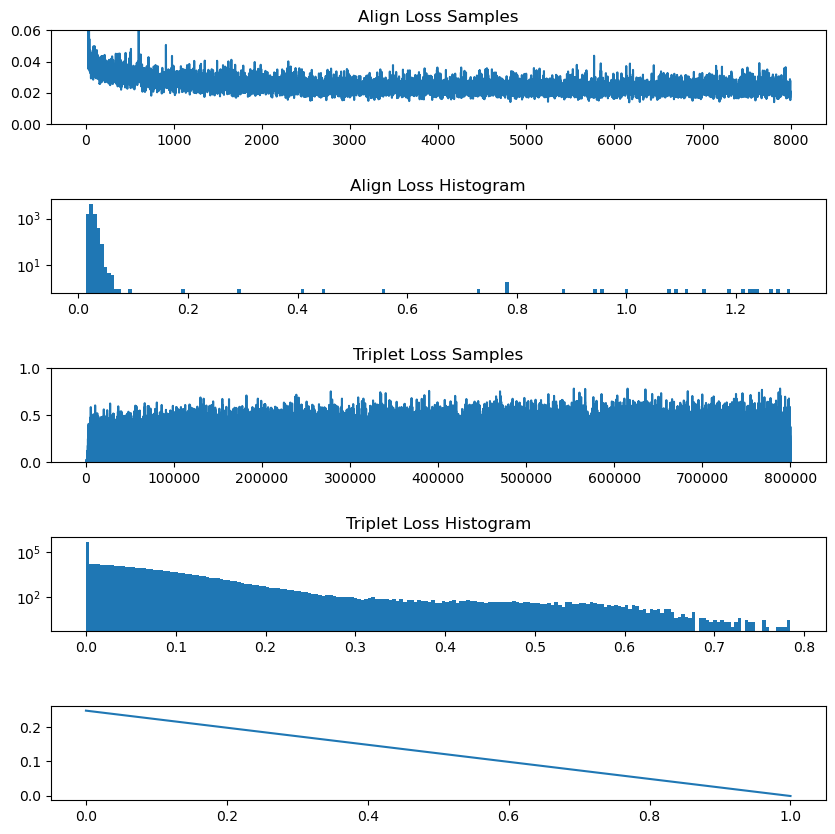

In [67]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(5, 1, 1)
plt.subplots_adjust(hspace=0.8)

ax1.plot(criterion.align_loss_samples)
ax1.set_title("Align Loss Samples")
ax1.set_ylim(0.0, 0.06)

ax2 = fig.add_subplot(5, 1, 2)
ax2.hist(criterion.align_loss_samples, bins=200)
ax2.set_title("Align Loss Histogram")
ax2.set_yscale('log')

ax3 = fig.add_subplot(5, 1, 3)
ax3.plot(criterion.triplet_loss_samples)
ax3.set_title("Triplet Loss Samples")
ax3.set_ylim(0, 1.0)

ax4 = fig.add_subplot(5, 1, 4)
ax4.hist(criterion.triplet_loss_samples, bins=200)
ax4.set_title("Triplet Loss Histogram")
ax4.set_yscale('log')

print("Min/Max/Avg Alignment Loss: {}/{}/{}".format(
    np.min(criterion.align_loss_samples),
    np.max(criterion.align_loss_samples),
    np.sum(criterion.align_loss_samples)/len(criterion.align_loss_samples)
))
print("Min/Max/Avg Triplet Loss: {}/{}/{}".format(
    np.min(criterion.triplet_loss_samples),
    np.max(criterion.triplet_loss_samples),
    np.sum(criterion.triplet_loss_samples)/len(criterion.triplet_loss_samples)))

ax5 = fig.add_subplot(5, 1, 5)

if (criterion.triplet_loss_margin_samples.shape[0] > 800000):
    criterion.triplet_loss_margin_samples = criterion.triplet_loss_margin_samples.reshape(-1, 2)
    
print(criterion.triplet_loss_margin_samples.shape)
print(criterion.triplet_loss_margin_samples[0][0], criterion.triplet_loss_margin_samples[0][1])
ax5.plot(criterion.triplet_loss_margin_samples[:][1])

plt.show()

In [ ]:
# Testing

from skbio.alignment import StripedSmithWaterman

def normalized_concordance(sA, sB, swa):
    tspan = swa['target_end_optimal'] - swa['target_begin']
    tval = sB[swa['target_begin']:swa['target_end_optimal']+1]
    qspan = swa['query_end'] - swa['query_begin']
    qval = sA[swa['query_begin']:swa['query_end']+1]
    concordance = sum(a==b for a, b in zip(tval, qval))
    return concordance / cfg['kmer_size']

def get_three_uniqe_indexes(max_index):
    vals=np.empty((0), dtype=int)
    while len(vals) < 3:
        val = np.random.choice(max_index-1)
        if val in vals:
            continue
        vals = np.append(vals, val)
    return vals

batchNum = 0
totalLoss = 0
total = 0
match = 0
mismatch = 0
discernment_error = np.empty((0))
mismatch_error = np.empty((0))
for APN, E in tqdm(test_loader):

    with torch.autocast(device_type=autocast_devtype, dtype=getattr(torch, cfg['parameter_dtype']), enabled=cfg['use_pytorch_amp']):
        yA, yP, yN = model.forward(APN)
        loss = criterion(yA, yP, yN, E[:,0], E[:,1])
        
    total += yA.shape[0]
    totalLoss += loss
        
    for i, iAPN in enumerate(APN):
        if False: # for debugging purposes.
            iA = torch.transpose(iAPN[:, :, 0], 0, 1)
            iP = torch.transpose(iAPN[:, :, 1], 0, 1)
            iN = torch.transpose(iAPN[:, :, 2], 0, 1)
        
            if (dev != 'cpu'):
                iA = iA.cpu()
                iP = iP.cpu()
                iN = iN.cpu()
            
            sA = onehot_to_seqstr(iA)
            sP = onehot_to_seqstr(iP)
            sN = onehot_to_seqstr(iN)
            #print("sA: {}".format(sA))
            #print("sP: {}".format(sP))
            #print("sN: {}".format(sN))
            sswA = StripedSmithWaterman(sA, score_size=2)
            swaAP = sswA(sP)
            swaAN = sswA(sN)
        
            nconcordAP = normalized_concordance(sA, sP, swaAP)
            nconcordAN = normalized_concordance(sA, sN, swaAN)
            #print("ssw(A,P): {}, ssw(A,N): {}".format(
            #    swaAP['optimal_alignment_score'],
            #    swaAN['optimal_alignment_score']
            #))
            

        embestAP = F.cosine_similarity(yA[i].unsqueeze(0), yP[i].unsqueeze(0)).item()
        embestAN = F.cosine_similarity(yA[i].unsqueeze(0), yN[i].unsqueeze(0)).item()
        #embestAP = torch.abs(torch.dot(yA[i], yP[i]) / (torch.norm(yA[i].unsqueeze(0)) * torch.norm(yP[i].unsqueeze(0))))
        #embestAN = torch.abs(torch.dot(yA[i], yN[i]) / (torch.norm(yA[i].unsqueeze(0)) * torch.norm(yN[i].unsqueeze(0))))
 
        #print(embestAP-embestAN)
        discernment_error = np.append(discernment_error, np.abs(embestAN-embestAP))
    
    while True:
        a1i, a2i, a3i = get_three_uniqe_indexes(cfg['batch_size'])
        i1 = torch.transpose(APN[a1i, :, :, 0], 0, 1)
        i2 = torch.transpose(APN[a2i, :, :, 0], 0, 1)
        i3 = torch.transpose(APN[a3i, :, :, 0], 0, 1)
        y1 = yA[a1i].unsqueeze(0)
        y2 = yA[a2i].unsqueeze(0)
        y3 = yA[a3i].unsqueeze(0)
        
        if (dev != 'cpu'):
            i1 = i1.cpu()
            i2 = i2.cpu()
            i3 = i3.cpu()
           
        s1 = onehot_to_seqstr(i1)
        s2 = onehot_to_seqstr(i2)
        s3 = onehot_to_seqstr(i3)
        ssw1 = StripedSmithWaterman(s1, score_size=2)
        swa12 = ssw1(s2)
        swa13 = ssw1(s3)
        embest12 = F.cosine_similarity(y1, y2).item()
        embest13 = F.cosine_similarity(y1, y3).item()
        #embest12 = torch.abs(torch.dot(y1[0], y2[0]) / (torch.norm(y1) * torch.norm(y2)))
        #embest13 = torch.abs(torch.dot(y1[0], y3[0]) / (torch.norm(y1) * torch.norm(y3)))

        #print(swa12['optimal_alignment_score'], swa13['optimal_alignment_score'])
        
        if swa12['optimal_alignment_score'] == swa13['optimal_alignment_score']:
            continue
            
        if swa12['optimal_alignment_score'] > swa13['optimal_alignment_score']:
            if embest12 > embest13:
                match += 1
            else:
                mismatch += 1
                mismatch_error = np.append(mismatch_error, np.abs(embest12-embest13))
        else:
            if embest13 > embest12:
                match += 1
            else:
                mismatch += 1
                mismatch_error = np.append(mismatch_error, np.abs(embest12-embest13)) 
        break
        
    batchNum = batchNum + 1
    if (batchNum % 100 == 0) and (batchNum != 0):
        print("Batch: {}...".format(batchNum))

print("Total: {}, NormLoss: {}, Match: {} of {} ({})".format(
    total, (totalLoss/total), match, match+mismatch, match/(match+mismatch)))

In [ ]:
max_discernment_error = np.max(discernment_error)
max_mismatch_error = np.max(mismatch_error)

fig, axs = plt.subplots(2, sharex=False)
plt.subplots_adjust(hspace=0.5)
axs[0].hist(discernment_error, bins=40, range=[0.0, max_discernment_error])
axs[0].set_title("Discernment Error max={}".format(max_discernment_error))
axs[1].hist(mismatch_error, bins=40, range=[0.0, max_mismatch_error])
axs[1].set_title("SWAEmb Type-I Estimation Error max={}".format(max_mismatch_error))